In [3]:
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path
path = Path.cwd().parents[0]
if str(path) not in sys.path:
    sys.path.append(str(path))

In [11]:
# Imports
trials = 50
n=100
front_door = False
minimise = True

results_kl = torch.load(path / "causalklgp/simulation_causalklgp_ntrial={0}_n={1}_frontdoor={2}_minimise={3}_addbase=True.pt".format(trials,n,front_door, minimise),
                         weights_only = True)
results_bimp = torch.load(path / "bayesimp/simulation_bayesimp_ntrial={0}_n={1}_frontdoor={2}_minimise={3}_addbase=True.pt".format(trials,n,front_door, minimise),
                         weights_only = True)
results_bgp = torch.load(path / "baseline/simulation_baseline_ntrial={0}_n={1}_frontdoor={2}_minimise={3}.pt".format(trials,n,front_door, minimise),
                         weights_only = True)
results_bo = torch.load(path / "naivebo/simulation_naivebo_ntrial={0}_n={1}_frontdoor={2}_minimise={3}.pt".format(trials,n,front_door, minimise),
                         weights_only = True)
# Getting dimensions and names
levels = results_kl[0]['cal_levels']
n_level = len(levels)
n_result_kl = len(results_kl)
n_model_kl = int(n_result_kl/trials)
n_result_bimp = len(results_bimp)
n_model_bimp = int(n_result_bimp/trials)
n_result_bgp = len(results_bgp)
n_model_bgp = int(n_result_bgp/trials)
n_result_bo = len(results_bo)
n_model_bo = int(n_result_bo/trials)
names = []

In [12]:
results = [results_bo, results_bgp,results_bimp,results_kl]
n_model = [n_model_bo, n_model_bgp, n_model_bimp, n_model_kl]

In [4]:
EYdoX_eval_kl = torch.zeros((len(results_kl[0]['EYdoXeval']), trials, n_model_kl))
EYdoX_eval_bimp = torch.zeros((len(results_bimp[0]['EYdoXeval']), trials, n_model_bimp))
EYdoX_eval_bgp = torch.zeros((len(results_bgp[0]['EYdoXeval']), trials, n_model_bgp))
EYdoX_eval_bo = torch.zeros((len(results_bo[0]['EYdoXeval']), trials, n_model_bo))

EYdoX_eval = [EYdoX_eval_bo,EYdoX_eval_bgp,EYdoX_eval_bimp,EYdoX_eval_kl]

for r in range(len(n_model)):
    for m in range(n_model[r]):
            for t in range(trials):
                EYdoX_eval[r][:,t,m] = results[r][trials*m + t]['EYdoXeval'][:,0]

In [5]:
doX_eval_kl = torch.zeros((len(results_kl[0]['doXeval']), trials, n_model_kl))
doX_eval_bimp = torch.zeros((len(results_bimp[0]['doXeval']), trials, n_model_bimp))
doX_eval_bgp = torch.zeros((len(results_bgp[0]['doXeval']), trials, n_model_bgp))
doX_eval_bo = torch.zeros((len(results_bo[0]['doXeval']), trials, n_model_bo))

doX_eval = [doX_eval_bo,doX_eval_bgp,doX_eval_bimp,doX_eval_kl]

for r in range(len(n_model)):
    for m in range(n_model[r]):
            for t in range(trials):
                doX_eval[r][:,t,m] = results[r][trials*m + t]['doXeval'][:,0]

In [6]:
# Getting best values
iters = len(results_kl[0]['EYdoXeval'])
best_eval_bo = torch.zeros((iters, trials, n_model_bo))
best_eval_bgp = torch.zeros((iters, trials, n_model_bgp))
best_eval_bimp = torch.zeros((iters, trials, n_model_bimp))
best_eval_kl = torch.zeros((iters, trials, n_model_kl))

best_eval = [best_eval_bo,best_eval_bgp,best_eval_bimp, best_eval_kl]

# Getting best values
for m in range(len(n_model)):
    for t in range(trials):
        for i in range(iters):
            if i == 0:
                best_eval[m][i,t] = EYdoX_eval[m][i,t] 
            else:
                if minimise:
                    if EYdoX_eval[m][i,t] < best_eval[m][:i,t].min():
                        best_eval[m][i,t] = EYdoX_eval[m][i,t]
                    else:
                         best_eval[m][i,t] =  best_eval[m][i-1,t]
                else:
                    if EYdoX_eval[m][i,t] > best_eval[m][:i,t].max():
                        best_eval[m][i,t] = EYdoX_eval[m][i,t]
                    else:
                         best_eval[m][i,t] =  best_eval[m][i-1,t]

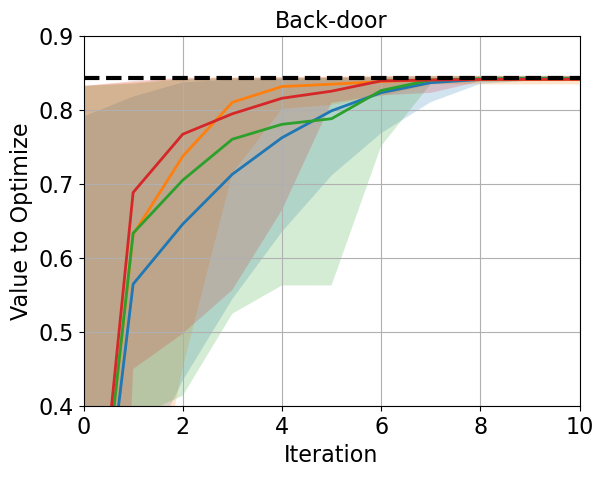

In [7]:
i=11
# Define names for the methods
names = ["BO", "CBO", "BayesIMP", "IMPspec"]

# Start plotting
for r in range(len(n_model)):
    plt.plot(-best_eval[r].mean(1)[:i], label=names[r], lw=2.0, ls="solid")
    plt.fill_between(
        torch.arange(min(len(best_eval[r]), i)),
        -best_eval[r].quantile(0.95, 1)[:i, 0],
        -best_eval[r].quantile(0.05, 1)[:i, 0],
        alpha=0.2
    )

# Add a horizontal line at the maximum value of 'int_data'
plt.axhline(-torch.min(results_kl[0]['int_data'][1]), color="black", ls="dashed", lw=3.0)

# Add grid, set limits, and adjust tick sizes
plt.grid()
plt.xlim(0, 10)
plt.ylim(0.4,0.9)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add legend, labels, and title with specified font size
#plt.legend(fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.ylabel("Value to Optimize", fontsize=16)
plt.title("Back-door", fontsize=16)

# Save the plot with tight bounding box
plt.savefig("CBO_convergence_profile_bd", bbox_inches="tight")

# Show the plot
plt.show()

In [8]:
# Saving results
torch.save(obj = [best_eval, torch.min(results_kl[0]['int_data'][1])],
           f = "bd_best_evals.pt")

In [9]:
import numpy as np

# === RMSE Calculation ===

# Initialize RMSE tensors for each method
rmse_kl = torch.zeros(len(results_kl))
rmse_bimp = torch.zeros(len(results_bimp))
rmse_bgp = torch.zeros(len(results_bgp))

# Populate RMSE tensors with RMSE values from results
for i in range(len(results_kl)):
    rmse_kl[i] = results_kl[i]['rmse']

for i in range(len(results_bimp)):
    rmse_bimp[i] = results_bimp[i]['rmse']

for i in range(len(results_bgp)):
    rmse_bgp[i] = results_bgp[i]['rmse']

# Reshape RMSE tensors to [trials, n_models] and convert to NumPy arrays
rmse_kl = rmse_kl.reshape(n_model_kl, trials).T.numpy()
rmse_bimp = rmse_bimp.reshape(n_model_bimp, trials).T.numpy()
rmse_bgp = rmse_bgp.reshape(n_model_bgp, trials).T.numpy()

/tmp/ipykernel_77664/3396437937.py:243: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1724888750493/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  levels_error_inner[:, m, :, t] = result_list[index]['post_levels'][inner_range_mask] - levels.T[None]


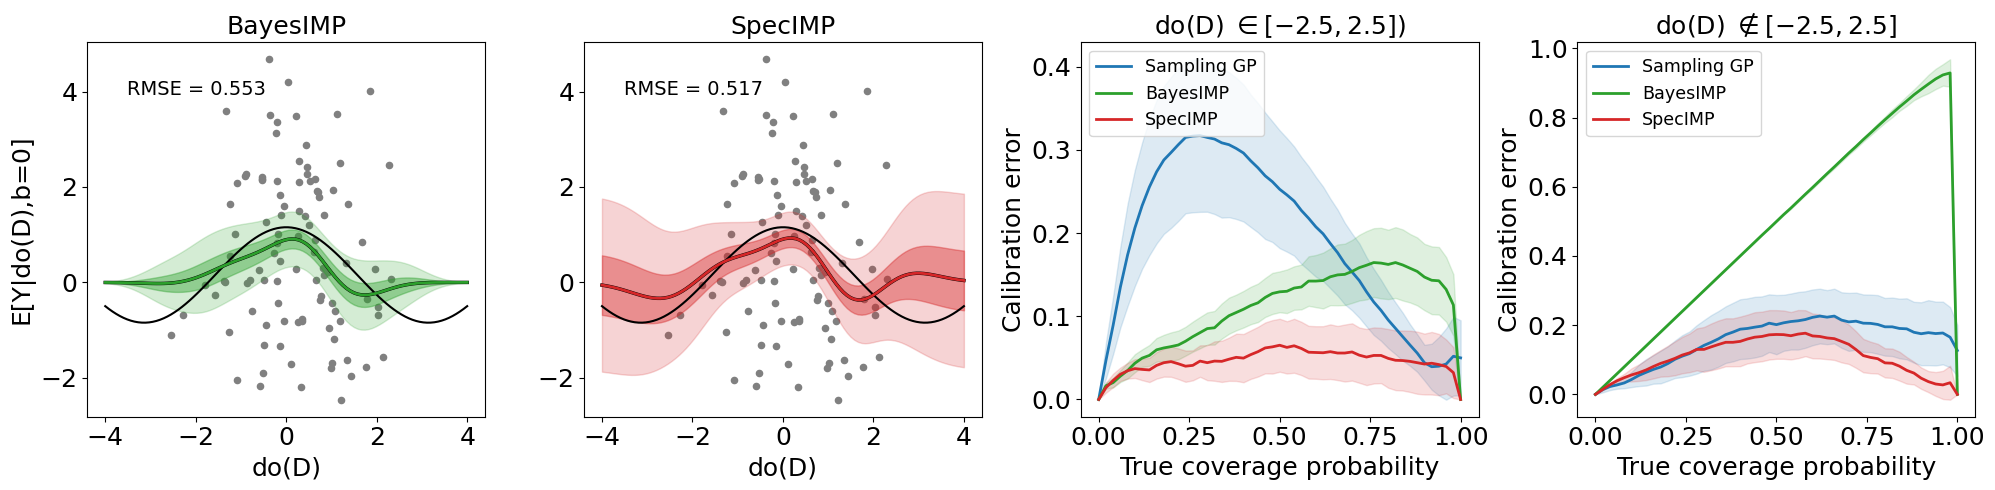

In [13]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch

# === Options and Hyperparameters ===

# Plotting hyperparameters
z1 = 1.96   # Corresponds to approximately 95% credible interval
z2 = 0.674  # Corresponds to approximately 50% credible interval (IQR)
q1 = 0.975  # 95% credible interval (97.5th percentile)
q2 = 0.75   # Corresponds to approximately 50% credible interval (75th percentile)

# Plot options
include_bgp = False
include_bgp_calibration = True  # Set to True to include BGP calibration loss plots even if BGP is excluded from the first set of charts
grid_alpha = 0.0                # Adjust this value between 0 (transparent) and 1 (opaque)
show_legend = False             # Set to True to include legends in subplots
adjust_y_limits = False         # Set to True to adjust Y-axis limits, False to use default limits
y_limits = (-1.25, 2)           # Y-axis limits for the first three plots (if adjust_y_limits is True)

# Figure size options
plot_height = 5             # Height of all plots
plot_width = 5              # Width of individual plots (excluding the last plot)
last_plot_width = 5         # Width of the last plot

# RMSE label options
base_fontsize = 12                     # Original font size
rmse_fontsize = int(base_fontsize * 1.2)  # Default size slightly larger than before
rmse_xpos_factor = 0.1                    # Default x-position factor, slightly closer to center
rmse_ypos_factor = 0.1                    # Default y-position factor (same height)

# RMSE data (Assumed to be provided)
rmse = {
    'bgp': rmse_bgp,   # Shape: [trials, n_model_bgp]
    'bimp': rmse_bimp, # Shape: [trials, n_model_bimp]
    'kl': rmse_kl      # Shape: [trials, n_model_kl]
}

# Reverse the order of methods and corresponding lists
if include_bgp:
    methods = ['bgp', 'bimp', 'kl']
    results = [results_bgp, results_bimp, results_kl]
    post_types = ['samples', 'moments', 'moments']
else:
    methods = ['bimp', 'kl']
    results = [results_bimp, results_kl]
    post_types = ['moments', 'moments']

# Add bgp to methods and results if only for calibration loss plotting
if not include_bgp and include_bgp_calibration:
    methods_for_calibration = ['bgp'] + methods
    results_for_calibration = [results_bgp] + results
else:
    methods_for_calibration = methods
    results_for_calibration = results

# Mapping of methods to display names
method_names = {
    'kl': 'IMPspec',
    'bimp': 'BayesIMP',
    'bgp': 'Sampling GP'
}

# Get default matplotlib colors
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Map methods to default colors
method_colors = {
    'bgp': default_colors[0],   # default blue
    'bimp': default_colors[2],  # default green
    'kl': default_colors[3]     # default red
}

# Font sizes
fontsize = int(base_fontsize * 1.5)    # Increase by 50%

# === End of Options and Hyperparameters ===

# Calculate total figure width based on individual plot widths
n_methods = len(methods)

# No spacer column
width_ratios = [1] * n_methods + [last_plot_width / plot_width, last_plot_width / plot_width]
ncols = n_methods + 2  # Number of columns (no spacer)
wspace = None          # Use default spacing between subplots

fig_width = sum(width_ratios) * plot_width
fig = plt.figure(figsize=(fig_width, plot_height))
gs = GridSpec(1, ncols, width_ratios=width_ratios, wspace=wspace)

axes = []
for idx in range(n_methods):
    ax = fig.add_subplot(gs[0, idx])
    axes.append(ax)
ax_calibration_inner = fig.add_subplot(gs[0, n_methods])
ax_calibration_outer = fig.add_subplot(gs[0, n_methods + 1])

axes.append(ax_calibration_inner)
axes.append(ax_calibration_outer)

# Model indices used for RMSE (consistent with models plotted)
model_inds = {'bgp': [0], 'bimp': [0], 'kl': [0]}  # Adjust indices as needed

# Loop over each method to generate the individual plots
for idx, (ax, method, result_list, post_type) in enumerate(zip(axes[:-2], methods, results, post_types)):
    result = result_list[0]  # Assuming result_list is a list of results per method
    X, Y = result['obs_data']
    doX, EYdoX = result['int_data']

    color = method_colors[method]

    ax.scatter(X, Y, color="grey", s=20, label='Observations')
    ax.plot(doX, EYdoX, color="black", label='True Function')

    method_name = method_names[method]

    if post_type == 'moments':
        mu, var = result['post_moments']
        std = var.sqrt()
        ax.fill_between(
            doX.view(-1),
            (mu - z1 * std).view(-1),
            (mu + z1 * std).view(-1),
            alpha=0.2,
            color=color,
            label='95% credible interval'
        )
        ax.fill_between(
            doX.view(-1),
            (mu - z2 * std).view(-1),
            (mu + z2 * std).view(-1),
            alpha=0.4,
            color=color,
            label='Interquartile range'
        )
        ax.plot(doX, mu, color="black", lw=2.5)
        ax.plot(doX, mu, color=color, lw=2, label='Posterior mean')
    elif post_type == 'samples':
        EYdoX_s = result['post_samples'][0]
        lower_q1 = EYdoX_s.quantile(1 - q1, dim=1)
        upper_q1 = EYdoX_s.quantile(q1, dim=1)
        lower_q2 = EYdoX_s.quantile(1 - q2, dim=1)
        upper_q2 = EYdoX_s.quantile(q2, dim=1)
        mean_prediction = EYdoX_s.mean(dim=1)

        ax.fill_between(
            doX.view(-1),
            lower_q1,
            upper_q1,
            alpha=0.2,
            color=color,
            label='95% credible interval'
        )
        ax.fill_between(
            doX.view(-1),
            lower_q2,
            upper_q2,
            alpha=0.4,
            color=color,
            label='Interquartile range'
        )
        ax.plot(doX, mean_prediction, color="black", lw=2.5)
        ax.plot(doX, mean_prediction, color=color, lw=2, label='Posterior mean')
    else:
        raise ValueError(f"Unknown post_type '{post_type}' for method '{method}'")

    # Update font sizes
    ax.set_title(f'{method_name}', fontsize=fontsize)
    ax.set_xlabel('do(D)', fontsize=fontsize)
    if idx == 0:
        ax.set_ylabel('E[Y|do(D),b=0]', fontsize=fontsize)
    else:
        ax.set_ylabel('')

    # Set Y-axis limits if specified and adjust_y_limits is True
    if adjust_y_limits and y_limits is not None:
        ax.set_ylim(y_limits)

    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    if show_legend:
        ax.legend(fontsize=fontsize * 0.8)
    ax.grid(True, alpha=grid_alpha)

    # === Add RMSE Text ===
    rmse_method = rmse[method]  # Shape: [trials, n_models]
    model_idx = model_inds[method][0]  # Index of the model used in plotting
    mean_rmse = rmse_method[:, model_idx].mean()  # Average RMSE over trials for the selected model
    rmse_text = f'RMSE = {mean_rmse:.3f}'  # Format RMSE value with 3 decimal places

    # Determine position for the text
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_pos = xlim[0] + rmse_xpos_factor * (xlim[1] - xlim[0])  # Adjusted x-position
    y_pos = ylim[1] - rmse_ypos_factor * (ylim[1] - ylim[0])   # Same height as before

    # Add text to the plot
    ax.text(
        x_pos,
        y_pos,
        rmse_text,
        fontsize=rmse_fontsize,  # Use the new RMSE font size
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

# === Plotting the Calibration Loss ===

# Parameters and initializations
z = 1.96  # For 95% confidence interval
B = 100  # num bootstrap replications
inner_l, inner_u = -2.5,2.5

n_models = {'bgp': n_model_bgp, 'bimp': n_model_bimp, 'kl': n_model_kl}
levels = levels.reshape(len(levels),)
n_level = len(levels)

# Define the inner and outer ranges
inner_range_mask = ((doX >= inner_l) & (doX <= inner_u)).reshape(len(doX),)
outer_range_mask = ~inner_range_mask

# Initialize dictionaries to store results
cal_loss_inner = {}
cal_loss_outer = {}
cal_loss_B_inner = {}
cal_loss_B_outer = {}

# Process results for calibration loss
for method, result_list in zip(methods_for_calibration, results_for_calibration):
    n_model = n_models[method]
    n_trials = trials

    # Initialize the calibration loss and bootstrap arrays for inner and outer ranges
    levels_error_inner = torch.zeros((inner_range_mask.sum().item(), n_model, n_level, n_trials))
    levels_error_outer = torch.zeros((outer_range_mask.sum().item(), n_model, n_level, n_trials))
    cal_loss_B_inner[method] = torch.zeros((B, n_model, n_level))  # To store bootstrap samples for inner range
    cal_loss_B_outer[method] = torch.zeros((B, n_model, n_level))  # To store bootstrap samples for outer range
    
    # Calculate levels_error for each trial and model
    for m in range(n_model):
        for t in range(n_trials):
            index = n_trials * m + t
            levels_error_inner[:, m, :, t] = result_list[index]['post_levels'][inner_range_mask] - levels.T[None]
            levels_error_outer[:, m, :, t] = result_list[index]['post_levels'][outer_range_mask] - levels.T[None]

    # Bootstrap procedure for inner and outer ranges
    for b in range(B):
        # Subsample trials with replacement
        sampled_indices = torch.randint(0, n_trials, (n_trials,))

        # Compute bootstrap calibration loss for each model and range
        cal_loss_B_inner[method][b] = levels_error_inner[...,sampled_indices].mean(-1).abs().mean(0)
        cal_loss_B_outer[method][b] = levels_error_outer[...,sampled_indices].mean(-1).abs().mean(0)

    # Compute the average calibration loss across all trials for inner and outer ranges
    cal_loss_inner[method] = levels_error_inner.mean(-1).abs().mean(0)
    cal_loss_outer[method] = levels_error_outer.mean(-1).abs().mean(0)

# Now cal_loss_inner and cal_loss_outer contain the average calibration loss for the inner and outer ranges respectively,
# and cal_loss_B_inner and cal_loss_B_outer contain the bootstrap estimates.

# Plotting the calibration loss for inner range
ax_calibration_inner.set_title(r'do(D) $\in [-2.5,2.5]$)', fontsize=fontsize)
ax_calibration_inner.set_xlabel('True coverage probability', fontsize=fontsize)
ax_calibration_inner.set_ylabel('Calibration error', fontsize=fontsize)
ax_calibration_inner.tick_params(axis='both', which='major', labelsize=fontsize)
ax_calibration_inner.grid(True, alpha=grid_alpha)

# Plotting the calibration loss for outer range
ax_calibration_outer.set_title(r'do(D) $\notin [-2.5,2.5]$', fontsize=fontsize)
ax_calibration_outer.set_xlabel('True coverage probability', fontsize=fontsize)
ax_calibration_outer.set_ylabel('Calibration error', fontsize=fontsize)
ax_calibration_outer.tick_params(axis='both', which='major', labelsize=fontsize)
ax_calibration_outer.grid(True, alpha=grid_alpha)

plot_inds = 2 * torch.arange(51)
model_inds_cal = {'bgp': [0], 'bimp': [0], 'kl': [0]}  # Adjust indices as needed

# Loop over methods to plot calibration loss for inner and outer ranges
for method in methods_for_calibration:
    # Plot for Inner Range
    cal_loss_mean_inner = cal_loss_inner[method]  # Mean over trials
    cal_loss_var_inner = cal_loss_B_inner[method].std(0)**2  # Variance over trials

    # Plot for Outer Range
    cal_loss_mean_outer = cal_loss_outer[method]  # Mean over trials
    cal_loss_var_outer = cal_loss_B_outer[method].std(0)**2  # Variance over trials

    n_model = n_models[method]

    for i in range(n_model):
        if i in model_inds_cal[method]:
            model_color = method_colors[method]
            method_label_inner = f"{method_names[method]}" if i == model_inds_cal[method][0] else None  # Avoid duplicate labels
            method_label_outer = f"{method_names[method]}" if i == model_inds_cal[method][0] else None  # Avoid duplicate labels

            # Plot inner range calibration loss
            mean_inner = cal_loss_mean_inner.T[plot_inds, i]
            std_error_inner = (cal_loss_var_inner.T[plot_inds, i]**0.5)
            ax_calibration_inner.plot(
                levels[plot_inds],
                mean_inner,
                color=model_color,
                lw=2.0,
                label=method_label_inner
            )
            ax_calibration_inner.fill_between(
                levels[plot_inds],
                mean_inner - z * std_error_inner,
                mean_inner + z * std_error_inner,
                color=model_color,
                alpha=0.15
            )

            # Plot outer range calibration loss
            mean_outer = cal_loss_mean_outer.T[plot_inds, i]
            std_error_outer = (cal_loss_var_outer.T[plot_inds, i]**0.5)
            ax_calibration_outer.plot(
                levels[plot_inds],
                mean_outer,
                color=model_color,
                lw=2.0,
                label=method_label_outer
            )
            ax_calibration_outer.fill_between(
                levels[plot_inds],
                mean_outer - z * std_error_outer,
                mean_outer + z * std_error_outer,
                color=model_color,
                alpha=0.15
            )

# Include legend for the central estimates
ax_calibration_inner.legend(fontsize=fontsize * 0.7, loc='upper left')  # Smaller font and moved to upper left
ax_calibration_outer.legend(fontsize=fontsize * 0.7, loc='upper left')  # Smaller font and moved to upper left

# Adjust layout
plt.tight_layout()
fig.savefig("Simulation_plots", bbox_inches="tight")
plt.show()

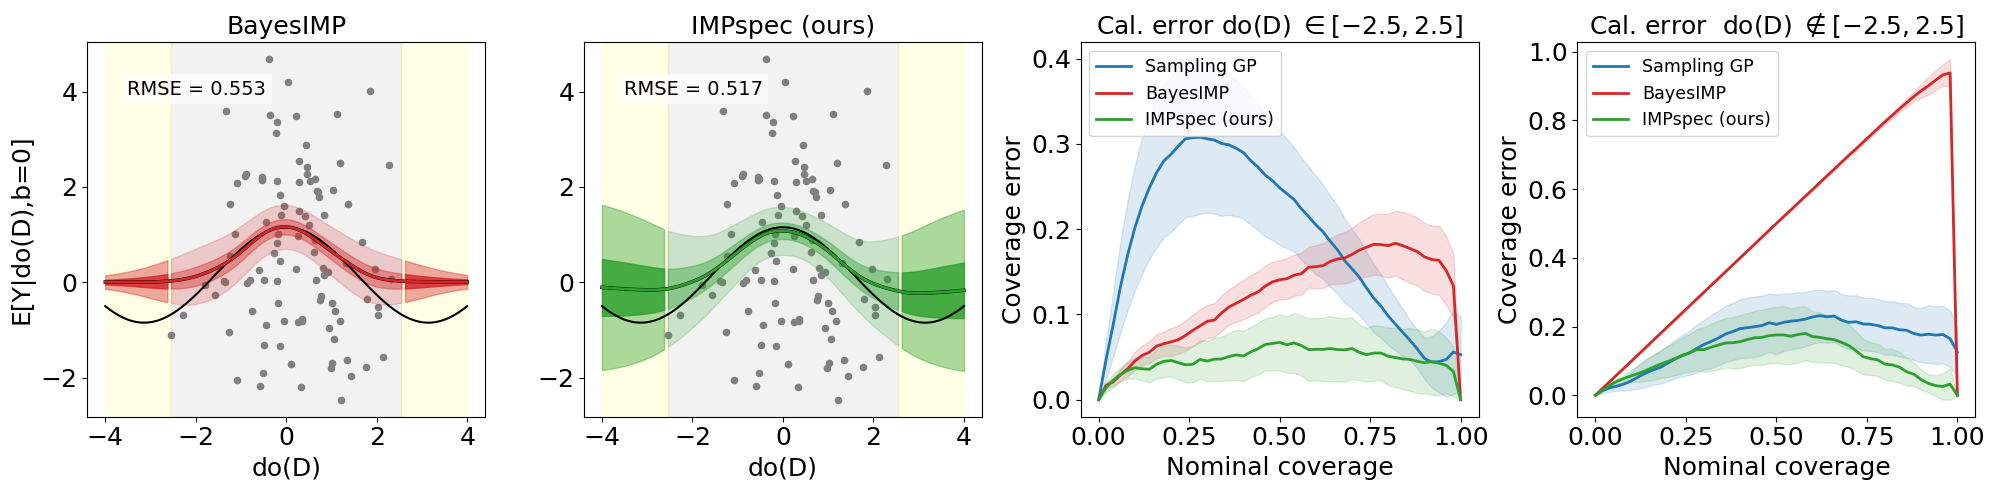

In [18]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch

# === Options and Hyperparameters ===

# Alpha values for confidence intervals (inner and outer range)
inner_ci_alpha_95 = 0.2  # Alpha for 95% confidence interval (inner range)
outer_ci_alpha_95 = 0.4  # Alpha for 95% confidence interval (outer range)
inner_ci_alpha_50 = 0.4  # Alpha for 50% confidence interval (inner range)
outer_ci_alpha_50 = 0.8  # Alpha for 50% confidence interval (outer range)

# Dynamically find the closest doX point just below -2.5 and above 2.5
inner_l = doX[doX < -2.5].max().item()  # Closest doX below or equal to -2.5
inner_u = doX[doX > 2.5].min().item()   # Closest doX above or equal to 2.5

# Define the inner and outer ranges based on adjusted bounds
inner_range_mask = ((doX >= inner_l) & (doX <= inner_u)).reshape(len(doX),)
outer_range_mask = ~inner_range_mask

# Plot options for shaded regions
shade_inner = True
shade_outer = True
inner_shade_color = 'grey'
outer_shade_color = 'yellow'
inner_alpha = 0.1  # Alpha for inner range shading
outer_alpha = 0.1  # Alpha for outer range shading

# Plotting hyperparameters
z1 = 1.96   # Corresponds to approximately 95% credible interval
z2 = 0.674  # Corresponds to approximately 50% credible interval (IQR)
q1 = 0.975  # 95% credible interval (97.5th percentile)
q2 = 0.75   # Corresponds to approximately 50% credible interval (75th percentile)

# Plot options
include_bgp = False
include_bgp_calibration = True  # Set to True to include BGP calibration loss plots even if BGP is excluded from the first set of charts
grid_alpha = 0.0                # Adjust this value between 0 (transparent) and 1 (opaque)
show_legend = False             # Set to True to include legends in subplots
adjust_y_limits = False         # Set to True to adjust Y-axis limits, False to use default limits
y_limits = (-1.25, 2)           # Y-axis limits for the first three plots (if adjust_y_limits is True)

# Figure size options
plot_height = 5             # Height of all plots
plot_width = 5              # Width of individual plots (excluding the last plot)
last_plot_width = 5         # Width of the last plot

# RMSE label options
base_fontsize = 12                     # Original font size
rmse_fontsize = int(base_fontsize * 1.2)  # Default size slightly larger than before
rmse_xpos_factor = 0.1                    # Default x-position factor, slightly closer to center
rmse_ypos_factor = 0.1                    # Default y-position factor (same height)



# RMSE data (Assumed to be provided)
rmse = {
    'bgp': rmse_bgp,   # Shape: [trials, n_model_bgp]
    'bimp': rmse_bimp, # Shape: [trials, n_model_bimp]
    'kl': rmse_kl      # Shape: [trials, n_model_kl]
}

# Reverse the order of methods and corresponding lists
if include_bgp:
    methods = ['bgp', 'bimp', 'kl']
    results = [results_bgp, results_bimp, results_kl]
    post_types = ['samples', 'moments', 'moments']
else:
    methods = ['bimp', 'kl']
    results = [results_bimp, results_kl]
    post_types = ['moments', 'moments']

# Add bgp to methods and results if only for calibration loss plotting
if not include_bgp and include_bgp_calibration:
    methods_for_calibration = ['bgp'] + methods
    results_for_calibration = [results_bgp] + results
else:
    methods_for_calibration = methods
    results_for_calibration = results

# Mapping of methods to display names
method_names = {
    'kl': 'IMPspec (ours)',
    'bimp': 'BayesIMP',
    'bgp': 'Sampling GP'
}

# Get default matplotlib colors
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Map methods to default colors
method_colors = {
    'bgp': default_colors[0],   # default blue
    'bimp': default_colors[3],  # default green
    'kl': default_colors[2]     # default red
}

# Font sizes
fontsize = int(base_fontsize * 1.5)    # Increase by 50%

# === End of Options and Hyperparameters ===

# Calculate total figure width based on individual plot widths
n_methods = len(methods)

# No spacer column
width_ratios = [1] * n_methods + [last_plot_width / plot_width, last_plot_width / plot_width]
ncols = n_methods + 2  # Number of columns (no spacer)
wspace = None          # Use default spacing between subplots

fig_width = sum(width_ratios) * plot_width
fig = plt.figure(figsize=(fig_width, plot_height))
gs = GridSpec(1, ncols, width_ratios=width_ratios, wspace=wspace)

axes = []
for idx in range(n_methods):
    ax = fig.add_subplot(gs[0, idx])
    axes.append(ax)
ax_calibration_inner = fig.add_subplot(gs[0, n_methods])
ax_calibration_outer = fig.add_subplot(gs[0, n_methods + 1])

axes.append(ax_calibration_inner)
axes.append(ax_calibration_outer)

# Model indices used for RMSE (consistent with models plotted)
model_inds = {'bgp': [0], 'bimp': [0], 'kl': [0]}  # Adjust indices as needed

# Shading the regions for the first two plots
for ax in axes[:-2]:  # Only apply to the first two single trial plots
    if shade_inner:
        ax.axvspan(inner_l, inner_u, color=inner_shade_color, alpha=inner_alpha, label="Inner Region")
    if shade_outer:
        # Use scalar values for min(doX) and max(doX) instead of sequences
        ax.axvspan(float(doX.min()), inner_l, color=outer_shade_color, alpha=outer_alpha, label="Outer Region")
        ax.axvspan(inner_u, float(doX.max()), color=outer_shade_color, alpha=outer_alpha)

# Loop over each method to generate the individual plots
for idx, (ax, method, result_list, post_type) in enumerate(zip(axes[:-2], methods, results, post_types)):
    result = result_list[0]  # Assuming result_list is a list of results per method
    X, Y = result['obs_data']
    doX, EYdoX = result['int_data']

    color = method_colors[method]

    ax.scatter(X, Y, color="grey", s=20, label='Observations')
    ax.plot(doX, EYdoX, color="black", label='True Function')

    method_name = method_names[method]

    if post_type == 'moments':
        mu, var = result['post_moments']
        mu *= 1/trials
        var *= 1/trials
        for t in range(1,trials):
            mu += result_list[t]['post_moments'][0]/trials
            var += result_list[t]['post_moments'][1]/trials
        std = var.sqrt()

        # Fill inner range (95% and 50% confidence intervals)
        ax.fill_between(
            doX.view(-1)[inner_range_mask],
            (mu - z1 * std).view(-1)[inner_range_mask],
            (mu + z1 * std).view(-1)[inner_range_mask],
            alpha=inner_ci_alpha_95,  # Apply alpha for 95% CI inner range
            color=color,
            label='95% credible interval (Inner)'
        )

        ax.fill_between(
            doX.view(-1)[inner_range_mask],
            (mu - z2 * std).view(-1)[inner_range_mask],
            (mu + z2 * std).view(-1)[inner_range_mask],
            alpha=inner_ci_alpha_50,  # Apply alpha for 50% CI inner range
            color=color,
            label='50% credible interval (Inner)'
        )

        # Plot outer range confidence intervals (95% and 50%) for two disjoint parts of the outer region
        # Left side of the outer range (doX < inner_l)
        ax.fill_between(
            doX.view(-1)[doX.view(-1) < inner_l],  # Left of inner region
            (mu - z1 * std).view(-1)[doX.view(-1) < inner_l],
            (mu + z1 * std).view(-1)[doX.view(-1) < inner_l],
            alpha=outer_ci_alpha_95,  # Apply alpha for 95% CI outer range (left)
            color=color,
            label='95% credible interval (Outer)'
        )
        
        ax.fill_between(
            doX.view(-1)[doX.view(-1) < inner_l],  # Left of inner region
            (mu - z2 * std).view(-1)[doX.view(-1) < inner_l],
            (mu + z2 * std).view(-1)[doX.view(-1) < inner_l],
            alpha=outer_ci_alpha_50,  # Apply alpha for 50% CI outer range (left)
            color=color,
            label='50% credible interval (Outer)'
        )
        
        # Right side of the outer range (doX > inner_u)
        ax.fill_between(
            doX.view(-1)[doX.view(-1) > inner_u],  # Right of inner region
            (mu - z1 * std).view(-1)[doX.view(-1) > inner_u],
            (mu + z1 * std).view(-1)[doX.view(-1) > inner_u],
            alpha=outer_ci_alpha_95,  # Apply alpha for 95% CI outer range (right)
            color=color,
            label='95% credible interval (Outer)'
        )
        
        ax.fill_between(
            doX.view(-1)[doX.view(-1) > inner_u],  # Right of inner region
            (mu - z2 * std).view(-1)[doX.view(-1) > inner_u],
            (mu + z2 * std).view(-1)[doX.view(-1) > inner_u],
            alpha=outer_ci_alpha_50,  # Apply alpha for 50% CI outer range (right)
            color=color,
            label='50% credible interval (Outer)'
        )

        ax.plot(doX, mu, color="black", lw=2.5)
        ax.plot(doX, mu, color=color, lw=2, label='Posterior mean')
    elif post_type == 'samples':
        EYdoX_s = result['post_samples'][0]
        lower_q1 = EYdoX_s.quantile(1 - q1, dim=1)
        upper_q1 = EYdoX_s.quantile(q1, dim=1)
        lower_q2 = EYdoX_s.quantile(1 - q2, dim=1)
        upper_q2 = EYdoX_s.quantile(q2, dim=1)
        mean_prediction = EYdoX_s.mean(dim=1)

        ax.fill_between(
            doX.view(-1),
            lower_q1,
            upper_q1,
            alpha=0.25,
            color=color,
            label='95% credible interval'
        )
        ax.fill_between(
            doX.view(-1),
            lower_q2,
            upper_q2,
            alpha=0.5,
            color=color,
            label='Interquartile range'
        )
        ax.plot(doX, mean_prediction, color="black", lw=2.5)
        ax.plot(doX, mean_prediction, color=color, lw=2, label='Posterior mean')
    else:
        raise ValueError(f"Unknown post_type '{post_type}' for method '{method}'")

    # Update font sizes
    ax.set_title(f'{method_name}', fontsize=fontsize)
    ax.set_xlabel('do(D)', fontsize=fontsize)
    if idx == 0:
        ax.set_ylabel('E[Y|do(D),b=0]', fontsize=fontsize)
    else:
        ax.set_ylabel('')

    # Set Y-axis limits if specified and adjust_y_limits is True
    if adjust_y_limits and y_limits is not None:
        ax.set_ylim(y_limits)

    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    if show_legend:
        ax.legend(fontsize=fontsize * 0.8)
    ax.grid(True, alpha=grid_alpha)

    # === Add RMSE Text ===
    rmse_method = rmse[method]  # Shape: [trials, n_models]
    model_idx = model_inds[method][0]  # Index of the model used in plotting
    mean_rmse = rmse_method[:, model_idx].mean()  # Average RMSE over trials for the selected model
    rmse_text = f'RMSE = {mean_rmse:.3f}'  # Format RMSE value with 3 decimal places

    # Determine position for the text
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_pos = xlim[0] + rmse_xpos_factor * (xlim[1] - xlim[0])  # Adjusted x-position
    y_pos = ylim[1] - rmse_ypos_factor * (ylim[1] - ylim[0])   # Same height as before

    # Add text to the plot
    ax.text(
        x_pos,
        y_pos,
        rmse_text,
        fontsize=rmse_fontsize,  # Use the new RMSE font size
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

# === Plotting the Calibration Loss ===

# Parameters and initializations
z = 1.96  # For 95% confidence interval
B = 100  # num bootstrap replications

n_models = {'bgp': n_model_bgp, 'bimp': n_model_bimp, 'kl': n_model_kl}
levels = levels.reshape(len(levels),)
n_level = len(levels)

# Define the inner and outer ranges
inner_range_mask = ((doX >= inner_l) & (doX <= inner_u)).reshape(len(doX),)
outer_range_mask = ~inner_range_mask

# Initialize dictionaries to store results
cal_loss_inner = {}
cal_loss_outer = {}
cal_loss_B_inner = {}
cal_loss_B_outer = {}

# Process results for calibration loss
for method, result_list in zip(methods_for_calibration, results_for_calibration):
    n_model = n_models[method]
    n_trials = trials

    # Initialize the calibration loss and bootstrap arrays for inner and outer ranges
    levels_error_inner = torch.zeros((inner_range_mask.sum().item(), n_model, n_level, n_trials))
    levels_error_outer = torch.zeros((outer_range_mask.sum().item(), n_model, n_level, n_trials))
    cal_loss_B_inner[method] = torch.zeros((B, n_model, n_level))  # To store bootstrap samples for inner range
    cal_loss_B_outer[method] = torch.zeros((B, n_model, n_level))  # To store bootstrap samples for outer range
    
    # Calculate levels_error for each trial and model
    for m in range(n_model):
        for t in range(n_trials):
            index = n_trials * m + t
            levels_error_inner[:, m, :, t] = result_list[index]['post_levels'][inner_range_mask] - levels.T[None]
            levels_error_outer[:, m, :, t] = result_list[index]['post_levels'][outer_range_mask] - levels.T[None]

    # Bootstrap procedure for inner and outer ranges
    for b in range(B):
        # Subsample trials with replacement
        sampled_indices = torch.randint(0, n_trials, (n_trials,))

        # Compute bootstrap calibration loss for each model and range
        cal_loss_B_inner[method][b] = levels_error_inner[...,sampled_indices].mean(-1).abs().mean(0)
        cal_loss_B_outer[method][b] = levels_error_outer[...,sampled_indices].mean(-1).abs().mean(0)

    # Compute the average calibration loss across all trials for inner and outer ranges
    cal_loss_inner[method] = levels_error_inner.mean(-1).abs().mean(0)
    cal_loss_outer[method] = levels_error_outer.mean(-1).abs().mean(0)

# Now cal_loss_inner and cal_loss_outer contain the average calibration loss for the inner and outer ranges respectively,
# and cal_loss_B_inner and cal_loss_B_outer contain the bootstrap estimates.

# Plotting the calibration loss for inner range
ax_calibration_inner.set_title(r'Cal. error do(D) $\in [-2.5,2.5]$', fontsize=fontsize)
ax_calibration_inner.set_xlabel('Nominal coverage', fontsize=fontsize)
ax_calibration_inner.set_ylabel('Coverage error', fontsize=fontsize)
ax_calibration_inner.tick_params(axis='both', which='major', labelsize=fontsize)
ax_calibration_inner.grid(True, alpha=grid_alpha)

# Plotting the calibration loss for outer range
ax_calibration_outer.set_title(r'Cal. error  do(D) $\notin [-2.5,2.5]$', fontsize=fontsize)
ax_calibration_outer.set_xlabel('Nominal coverage', fontsize=fontsize)
ax_calibration_outer.set_ylabel('Coverage error', fontsize=fontsize)
ax_calibration_outer.tick_params(axis='both', which='major', labelsize=fontsize)
ax_calibration_outer.grid(True, alpha=grid_alpha)

plot_inds = 2 * torch.arange(51)
model_inds_cal = {'bgp': [0], 'bimp': [0], 'kl': [0]}  # Adjust indices as needed

# Loop over methods to plot calibration loss for inner and outer ranges
for method in methods_for_calibration:
    # Plot for Inner Range
    cal_loss_mean_inner = cal_loss_inner[method]  # Mean over trials
    cal_loss_var_inner = cal_loss_B_inner[method].std(0)**2  # Variance over trials

    # Plot for Outer Range
    cal_loss_mean_outer = cal_loss_outer[method]  # Mean over trials
    cal_loss_var_outer = cal_loss_B_outer[method].std(0)**2  # Variance over trials

    n_model = n_models[method]

    for i in range(n_model):
        if i in model_inds_cal[method]:
            model_color = method_colors[method]
            method_label_inner = f"{method_names[method]}" if i == model_inds_cal[method][0] else None  # Avoid duplicate labels
            method_label_outer = f"{method_names[method]}" if i == model_inds_cal[method][0] else None  # Avoid duplicate labels

            # Plot inner range calibration loss
            mean_inner = cal_loss_mean_inner.T[plot_inds, i]
            std_error_inner = (cal_loss_var_inner.T[plot_inds, i]**0.5)
            ax_calibration_inner.plot(
                levels[plot_inds],
                mean_inner,
                color=model_color,
                lw=2.0,
                label=method_label_inner
            )
            ax_calibration_inner.fill_between(
                levels[plot_inds],
                mean_inner - z * std_error_inner,
                mean_inner + z * std_error_inner,
                color=model_color,
                alpha=0.15
            )

            # Plot outer range calibration loss
            mean_outer = cal_loss_mean_outer.T[plot_inds, i]
            std_error_outer = (cal_loss_var_outer.T[plot_inds, i]**0.5)
            ax_calibration_outer.plot(
                levels[plot_inds],
                mean_outer,
                color=model_color,
                lw=2.0,
                label=method_label_outer
            )
            ax_calibration_outer.fill_between(
                levels[plot_inds],
                mean_outer - z * std_error_outer,
                mean_outer + z * std_error_outer,
                color=model_color,
                alpha=0.15
            )

# Include legend for the central estimates
ax_calibration_inner.legend(fontsize=fontsize * 0.7, loc='upper left')  # Smaller font and moved to upper left
ax_calibration_outer.legend(fontsize=fontsize * 0.7, loc='upper left')  # Smaller font and moved to upper left

# Adjust layout
plt.tight_layout()
fig.savefig("Simulation_plots", bbox_inches="tight")
plt.show()

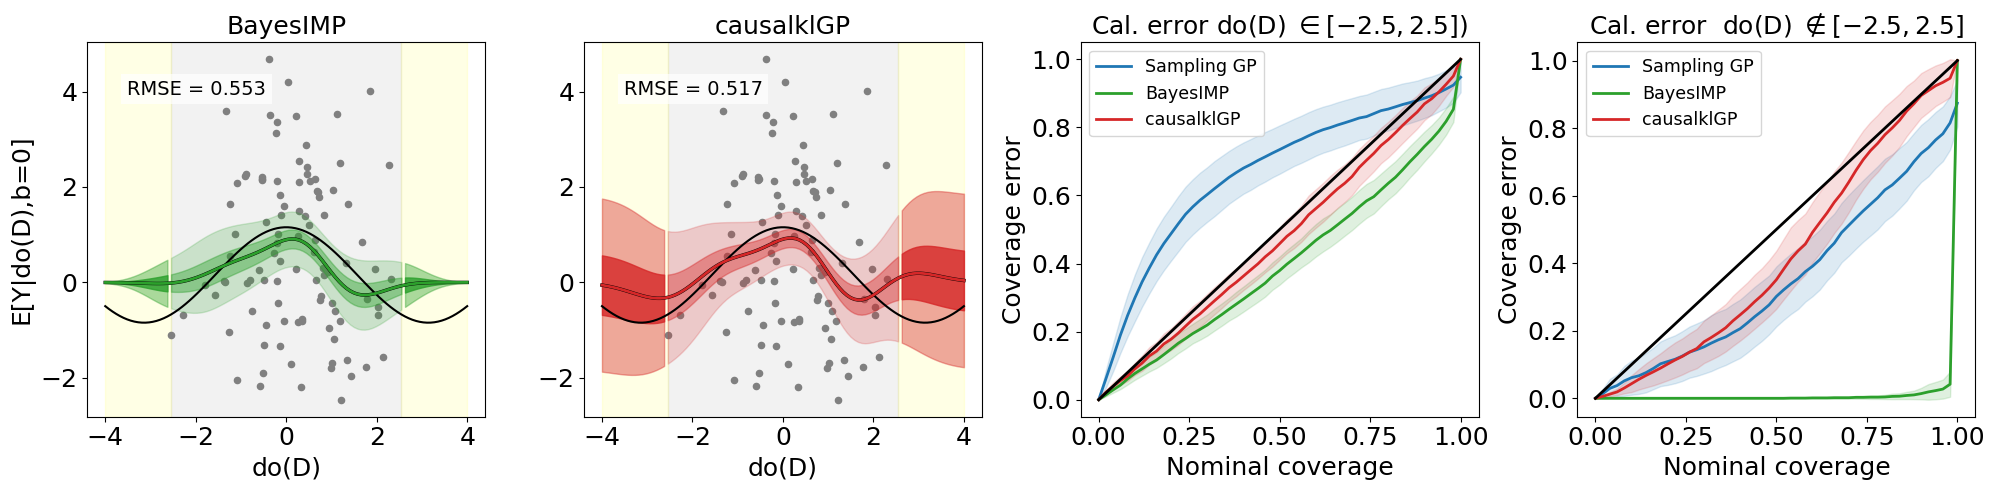

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch

# === Options and Hyperparameters ===

# Alpha values for confidence intervals (inner and outer range)
inner_ci_alpha_95 = 0.2  # Alpha for 95% confidence interval (inner range)
outer_ci_alpha_95 = 0.4  # Alpha for 95% confidence interval (outer range)
inner_ci_alpha_50 = 0.4  # Alpha for 50% confidence interval (inner range)
outer_ci_alpha_50 = 0.8  # Alpha for 50% confidence interval (outer range)

# Dynamically find the closest doX point just below -2.5 and above 2.5
inner_l = doX[doX < -2.5].max().item()  # Closest doX below or equal to -2.5
inner_u = doX[doX > 2.5].min().item()   # Closest doX above or equal to 2.5

# Define the inner and outer ranges based on adjusted bounds
inner_range_mask = ((doX >= inner_l) & (doX <= inner_u)).reshape(len(doX),)
outer_range_mask = ~inner_range_mask

# Plot options for shaded regions
shade_inner = True
shade_outer = True
inner_shade_color = 'grey'
outer_shade_color = 'yellow'
inner_alpha = 0.1  # Alpha for inner range shading
outer_alpha = 0.1  # Alpha for outer range shading

# Plotting hyperparameters
z1 = 1.96   # Corresponds to approximately 95% credible interval
z2 = 0.674  # Corresponds to approximately 50% credible interval (IQR)
q1 = 0.975  # 95% credible interval (97.5th percentile)
q2 = 0.75   # Corresponds to approximately 50% credible interval (75th percentile)

# Plot options
include_bgp = False
include_bgp_calibration = True  # Set to True to include BGP calibration loss plots even if BGP is excluded from the first set of charts
grid_alpha = 0.0                # Adjust this value between 0 (transparent) and 1 (opaque)
show_legend = False             # Set to True to include legends in subplots
adjust_y_limits = False         # Set to True to adjust Y-axis limits, False to use default limits
y_limits = (-1.25, 2)           # Y-axis limits for the first three plots (if adjust_y_limits is True)

# Figure size options
plot_height = 5             # Height of all plots
plot_width = 5              # Width of individual plots (excluding the last plot)
last_plot_width = 5         # Width of the last plot

# RMSE label options
base_fontsize = 12                     # Original font size
rmse_fontsize = int(base_fontsize * 1.2)  # Default size slightly larger than before
rmse_xpos_factor = 0.1                    # Default x-position factor, slightly closer to center
rmse_ypos_factor = 0.1                    # Default y-position factor (same height)



# RMSE data (Assumed to be provided)
rmse = {
    'bgp': rmse_bgp,   # Shape: [trials, n_model_bgp]
    'bimp': rmse_bimp, # Shape: [trials, n_model_bimp]
    'kl': rmse_kl      # Shape: [trials, n_model_kl]
}

# Reverse the order of methods and corresponding lists
if include_bgp:
    methods = ['bgp', 'bimp', 'kl']
    results = [results_bgp, results_bimp, results_kl]
    post_types = ['samples', 'moments', 'moments']
else:
    methods = ['bimp', 'kl']
    results = [results_bimp, results_kl]
    post_types = ['moments', 'moments']

# Add bgp to methods and results if only for calibration loss plotting
if not include_bgp and include_bgp_calibration:
    methods_for_calibration = ['bgp'] + methods
    results_for_calibration = [results_bgp] + results
else:
    methods_for_calibration = methods
    results_for_calibration = results

# Mapping of methods to display names
method_names = {
    'kl': 'IMPspec',
    'bimp': 'BayesIMP',
    'bgp': 'Sampling GP'
}

# Get default matplotlib colors
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Map methods to default colors
method_colors = {
    'bgp': default_colors[0],   # default blue
    'bimp': default_colors[2],  # default green
    'kl': default_colors[3]     # default red
}

# Font sizes
fontsize = int(base_fontsize * 1.5)    # Increase by 50%

# === End of Options and Hyperparameters ===

# Calculate total figure width based on individual plot widths
n_methods = len(methods)

# No spacer column
width_ratios = [1] * n_methods + [last_plot_width / plot_width, last_plot_width / plot_width]
ncols = n_methods + 2  # Number of columns (no spacer)
wspace = None          # Use default spacing between subplots

fig_width = sum(width_ratios) * plot_width
fig = plt.figure(figsize=(fig_width, plot_height))
gs = GridSpec(1, ncols, width_ratios=width_ratios, wspace=wspace)

axes = []
for idx in range(n_methods):
    ax = fig.add_subplot(gs[0, idx])
    axes.append(ax)
ax_calibration_inner = fig.add_subplot(gs[0, n_methods])
ax_calibration_outer = fig.add_subplot(gs[0, n_methods + 1])

axes.append(ax_calibration_inner)
axes.append(ax_calibration_outer)

# Model indices used for RMSE (consistent with models plotted)
model_inds = {'bgp': [0], 'bimp': [0], 'kl': [0]}  # Adjust indices as needed

# Shading the regions for the first two plots
for ax in axes[:-2]:  # Only apply to the first two single trial plots
    if shade_inner:
        ax.axvspan(inner_l, inner_u, color=inner_shade_color, alpha=inner_alpha, label="Inner Region")
    if shade_outer:
        # Use scalar values for min(doX) and max(doX) instead of sequences
        ax.axvspan(float(doX.min()), inner_l, color=outer_shade_color, alpha=outer_alpha, label="Outer Region")
        ax.axvspan(inner_u, float(doX.max()), color=outer_shade_color, alpha=outer_alpha)

# Loop over each method to generate the individual plots
for idx, (ax, method, result_list, post_type) in enumerate(zip(axes[:-2], methods, results, post_types)):
    result = result_list[0]  # Assuming result_list is a list of results per method
    X, Y = result['obs_data']
    doX, EYdoX = result['int_data']

    color = method_colors[method]

    ax.scatter(X, Y, color="grey", s=20, label='Observations')
    ax.plot(doX, EYdoX, color="black", label='True Function')

    method_name = method_names[method]

    if post_type == 'moments':
        mu, var = result['post_moments']
        std = var.sqrt()

        # Fill inner range (95% and 50% confidence intervals)
        ax.fill_between(
            doX.view(-1)[inner_range_mask],
            (mu - z1 * std).view(-1)[inner_range_mask],
            (mu + z1 * std).view(-1)[inner_range_mask],
            alpha=inner_ci_alpha_95,  # Apply alpha for 95% CI inner range
            color=color,
            label='95% credible interval (Inner)'
        )

        ax.fill_between(
            doX.view(-1)[inner_range_mask],
            (mu - z2 * std).view(-1)[inner_range_mask],
            (mu + z2 * std).view(-1)[inner_range_mask],
            alpha=inner_ci_alpha_50,  # Apply alpha for 50% CI inner range
            color=color,
            label='50% credible interval (Inner)'
        )

        # Plot outer range confidence intervals (95% and 50%) for two disjoint parts of the outer region
        # Left side of the outer range (doX < inner_l)
        ax.fill_between(
            doX.view(-1)[doX.view(-1) < inner_l],  # Left of inner region
            (mu - z1 * std).view(-1)[doX.view(-1) < inner_l],
            (mu + z1 * std).view(-1)[doX.view(-1) < inner_l],
            alpha=outer_ci_alpha_95,  # Apply alpha for 95% CI outer range (left)
            color=color,
            label='95% credible interval (Outer)'
        )
        
        ax.fill_between(
            doX.view(-1)[doX.view(-1) < inner_l],  # Left of inner region
            (mu - z2 * std).view(-1)[doX.view(-1) < inner_l],
            (mu + z2 * std).view(-1)[doX.view(-1) < inner_l],
            alpha=outer_ci_alpha_50,  # Apply alpha for 50% CI outer range (left)
            color=color,
            label='50% credible interval (Outer)'
        )
        
        # Right side of the outer range (doX > inner_u)
        ax.fill_between(
            doX.view(-1)[doX.view(-1) > inner_u],  # Right of inner region
            (mu - z1 * std).view(-1)[doX.view(-1) > inner_u],
            (mu + z1 * std).view(-1)[doX.view(-1) > inner_u],
            alpha=outer_ci_alpha_95,  # Apply alpha for 95% CI outer range (right)
            color=color,
            label='95% credible interval (Outer)'
        )
        
        ax.fill_between(
            doX.view(-1)[doX.view(-1) > inner_u],  # Right of inner region
            (mu - z2 * std).view(-1)[doX.view(-1) > inner_u],
            (mu + z2 * std).view(-1)[doX.view(-1) > inner_u],
            alpha=outer_ci_alpha_50,  # Apply alpha for 50% CI outer range (right)
            color=color,
            label='50% credible interval (Outer)'
        )

        ax.plot(doX, mu, color="black", lw=2.5)
        ax.plot(doX, mu, color=color, lw=2, label='Posterior mean')
    elif post_type == 'samples':
        EYdoX_s = result['post_samples'][0]
        lower_q1 = EYdoX_s.quantile(1 - q1, dim=1)
        upper_q1 = EYdoX_s.quantile(q1, dim=1)
        lower_q2 = EYdoX_s.quantile(1 - q2, dim=1)
        upper_q2 = EYdoX_s.quantile(q2, dim=1)
        mean_prediction = EYdoX_s.mean(dim=1)

        ax.fill_between(
            doX.view(-1),
            lower_q1,
            upper_q1,
            alpha=0.25,
            color=color,
            label='95% credible interval'
        )
        ax.fill_between(
            doX.view(-1),
            lower_q2,
            upper_q2,
            alpha=0.5,
            color=color,
            label='Interquartile range'
        )
        ax.plot(doX, mean_prediction, color="black", lw=2.5)
        ax.plot(doX, mean_prediction, color=color, lw=2, label='Posterior mean')
    else:
        raise ValueError(f"Unknown post_type '{post_type}' for method '{method}'")

    # Update font sizes
    ax.set_title(f'{method_name}', fontsize=fontsize)
    ax.set_xlabel('do(D)', fontsize=fontsize)
    if idx == 0:
        ax.set_ylabel('E[Y|do(D),b=0]', fontsize=fontsize)
    else:
        ax.set_ylabel('')

    # Set Y-axis limits if specified and adjust_y_limits is True
    if adjust_y_limits and y_limits is not None:
        ax.set_ylim(y_limits)

    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    if show_legend:
        ax.legend(fontsize=fontsize * 0.8)
    ax.grid(True, alpha=grid_alpha)

    # === Add RMSE Text ===
    rmse_method = rmse[method]  # Shape: [trials, n_models]
    model_idx = model_inds[method][0]  # Index of the model used in plotting
    mean_rmse = rmse_method[:, model_idx].mean()  # Average RMSE over trials for the selected model
    rmse_text = f'RMSE = {mean_rmse:.3f}'  # Format RMSE value with 3 decimal places

    # Determine position for the text
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_pos = xlim[0] + rmse_xpos_factor * (xlim[1] - xlim[0])  # Adjusted x-position
    y_pos = ylim[1] - rmse_ypos_factor * (ylim[1] - ylim[0])   # Same height as before

    # Add text to the plot
    ax.text(
        x_pos,
        y_pos,
        rmse_text,
        fontsize=rmse_fontsize,  # Use the new RMSE font size
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

# === Plotting the Calibration Loss ===

# Parameters and initializations
z = 1.96  # For 95% confidence interval
B = 100  # num bootstrap replications

n_models = {'bgp': n_model_bgp, 'bimp': n_model_bimp, 'kl': n_model_kl}
levels = levels.reshape(len(levels),)
n_level = len(levels)

# Define the inner and outer ranges
inner_range_mask = ((doX >= inner_l) & (doX <= inner_u)).reshape(len(doX),)
outer_range_mask = ~inner_range_mask

# Initialize dictionaries to store results
cal_loss_inner = {}
cal_loss_outer = {}
cal_loss_B_inner = {}
cal_loss_B_outer = {}

# Process results for calibration loss
for method, result_list in zip(methods_for_calibration, results_for_calibration):
    n_model = n_models[method]
    n_trials = trials

    # Initialize the calibration loss and bootstrap arrays for inner and outer ranges
    levels_error_inner = torch.zeros((inner_range_mask.sum().item(), n_model, n_level, n_trials))
    levels_error_outer = torch.zeros((outer_range_mask.sum().item(), n_model, n_level, n_trials))
    cal_loss_B_inner[method] = torch.zeros((B, n_model, n_level))  # To store bootstrap samples for inner range
    cal_loss_B_outer[method] = torch.zeros((B, n_model, n_level))  # To store bootstrap samples for outer range
    
    # Calculate levels_error for each trial and model
    for m in range(n_model):
        for t in range(n_trials):
            index = n_trials * m + t
            levels_error_inner[:, m, :, t] = result_list[index]['post_levels'][inner_range_mask] 
            levels_error_outer[:, m, :, t] = result_list[index]['post_levels'][outer_range_mask]

    # Bootstrap procedure for inner and outer ranges
    for b in range(B):
        # Subsample trials with replacement
        sampled_indices = torch.randint(0, n_trials, (n_trials,))

        # Compute bootstrap calibration loss for each model and range
        cal_loss_B_inner[method][b] = levels_error_inner[...,sampled_indices].mean(-1).mean(0)
        cal_loss_B_outer[method][b] = levels_error_outer[...,sampled_indices].mean(-1).mean(0)

    # Compute the average calibration loss across all trials for inner and outer ranges
    cal_loss_inner[method] = levels_error_inner.mean(-1).mean(0)
    cal_loss_outer[method] = levels_error_outer.mean(-1).mean(0)

# Now cal_loss_inner and cal_loss_outer contain the average calibration loss for the inner and outer ranges respectively,
# and cal_loss_B_inner and cal_loss_B_outer contain the bootstrap estimates.

# Plotting the calibration loss for inner range
ax_calibration_inner.set_title(r'Cal. error do(D) $\in [-2.5,2.5]$)', fontsize=fontsize)
ax_calibration_inner.set_xlabel('Nominal coverage', fontsize=fontsize)
ax_calibration_inner.set_ylabel('Coverage error', fontsize=fontsize)
ax_calibration_inner.tick_params(axis='both', which='major', labelsize=fontsize)
ax_calibration_inner.grid(True, alpha=grid_alpha)

# Plotting the calibration loss for outer range
ax_calibration_outer.set_title(r'Cal. error  do(D) $\notin [-2.5,2.5]$', fontsize=fontsize)
ax_calibration_outer.set_xlabel('Nominal coverage', fontsize=fontsize)
ax_calibration_outer.set_ylabel('Coverage error', fontsize=fontsize)
ax_calibration_outer.tick_params(axis='both', which='major', labelsize=fontsize)
ax_calibration_outer.grid(True, alpha=grid_alpha)

plot_inds = 2 * torch.arange(51)
model_inds_cal = {'bgp': [0], 'bimp': [0], 'kl': [0]}  # Adjust indices as needed

# Loop over methods to plot calibration loss for inner and outer ranges
for method in methods_for_calibration:
    # Plot for Inner Range
    cal_loss_mean_inner = cal_loss_inner[method]  # Mean over trials
    cal_loss_var_inner = cal_loss_B_inner[method].std(0)**2  # Variance over trials

    # Plot for Outer Range
    cal_loss_mean_outer = cal_loss_outer[method]  # Mean over trials
    cal_loss_var_outer = cal_loss_B_outer[method].std(0)**2  # Variance over trials

    n_model = n_models[method]

    for i in range(n_model):
        if i in model_inds_cal[method]:
            model_color = method_colors[method]
            method_label_inner = f"{method_names[method]}" if i == model_inds_cal[method][0] else None  # Avoid duplicate labels
            method_label_outer = f"{method_names[method]}" if i == model_inds_cal[method][0] else None  # Avoid duplicate labels

            # Plot inner range calibration loss
            mean_inner = cal_loss_mean_inner.T[plot_inds, i]
            std_error_inner = (cal_loss_var_inner.T[plot_inds, i]**0.5)
            ax_calibration_inner.plot(
                levels[plot_inds],
                mean_inner,
                color=model_color,
                lw=2.0,
                label=method_label_inner
            )
            ax_calibration_inner.fill_between(
                levels[plot_inds],
                mean_inner - z * std_error_inner,
                mean_inner + z * std_error_inner,
                color=model_color,
                alpha=0.15
            )

            # Plot outer range calibration loss
            mean_outer = cal_loss_mean_outer.T[plot_inds, i]
            std_error_outer = (cal_loss_var_outer.T[plot_inds, i]**0.5)
            ax_calibration_outer.plot(
                levels[plot_inds],
                mean_outer,
                color=model_color,
                lw=2.0,
                label=method_label_outer
            )
            ax_calibration_outer.fill_between(
                levels[plot_inds],
                mean_outer - z * std_error_outer,
                mean_outer + z * std_error_outer,
                color=model_color,
                alpha=0.15
            )
ax_calibration_inner.plot(
    levels[plot_inds],
    levels[plot_inds],
    color="black",
    lw=2.0,
    label="_nolegend_"  # This ensures it won't show up in the legend
)
ax_calibration_outer.plot(
    levels[plot_inds],
    levels[plot_inds],
    color="black",
    lw=2.0,
    label="_nolegend_"  # This ensures it won't show up in the legend
)
# Include legend for the central estimates
ax_calibration_inner.legend(fontsize=fontsize * 0.7, loc='upper left')  # Smaller font and moved to upper left
ax_calibration_outer.legend(fontsize=fontsize * 0.7, loc='upper left')  # Smaller font and moved to upper left

# Adjust layout
plt.tight_layout()
fig.savefig("Simulation_plots", bbox_inches="tight")
plt.show()

In [7]:
from tabulate import tabulate

# === LaTeX Table Generation ===

# Option to control standard error calculation
use_sqrt_trials = False

# Create a dictionary to store RMSE arrays with updated method names
rmse = {
    'IMPspec': rmse_kl[:, 0],
    'BayesIMP': rmse_bimp[:, 0],
    'Sampling GP': rmse_bgp[:, 0]
}

# Prepare table data
table = []
table_headers = ['Method', 'RMSE', 'Calibration Score (Inner)', 'Calibration Score (Outer)']

# Define the mapping from display names to cal_loss keys and model indices
method_mapping = {
    'IMPspec': {'cal_loss_key': 'kl', 'model_idx': 0},          # Model 0
    'BayesIMP': {'cal_loss_key': 'bimp', 'model_idx': 0},
    'Sampling GP': {'cal_loss_key': 'bgp', 'model_idx': 0},
}

# Define the methods to include in the table with updated ordering
methods_for_table = ['Sampling GP', 'BayesIMP', 'IMPspec']

# Collect mean RMSE and Calibration Scores for identifying the best ones
rmse_means = {}
cal_means_inner = {}
cal_means_outer = {}

for method in methods_for_table:
    cal_loss_key = method_mapping[method]['cal_loss_key']
    model_idx = method_mapping[method]['model_idx']
    
    # Calculate mean and standard error for RMSE
    mean_rmse = rmse[method].mean()
    se_rmse = rmse[method].std(ddof=1) / np.sqrt(trials) if use_sqrt_trials else rmse[method].std(ddof=1)
    
    # Calculate mean and standard error for Calibration Score (Inner and Outer)
    mean_cal_inner = cal_loss_inner[cal_loss_key][model_idx].mean() 
    se_cal_inner = cal_loss_B_inner[cal_loss_key].std(0)[model_idx].mean()
    
    mean_cal_outer = cal_loss_outer[cal_loss_key][model_idx].mean() 
    se_cal_outer = cal_loss_B_outer[cal_loss_key].std(0)[model_idx].mean()
    
    # Store means for later comparison
    rmse_means[method] = mean_rmse
    cal_means_inner[method] = mean_cal_inner
    cal_means_outer[method] = mean_cal_outer
    
    # Append to table with "mean ± se" formatting (temporary, will bold later)
    table.append([
        method, 
        f'{mean_rmse:.3f} ± {se_rmse:.3f}', 
        f'{mean_cal_inner:.3f} ± {se_cal_inner:.3f}',
        f'{mean_cal_outer:.3f} ± {se_cal_outer:.3f}'
    ])

# Identify the best (smallest) RMSE, Calibration Score (Inner), and Calibration Score (Outer)
best_rmse_method = min(rmse_means, key=rmse_means.get)
best_cal_method_inner = min(cal_means_inner, key=cal_means_inner.get)
best_cal_method_outer = min(cal_means_outer, key=cal_means_outer.get)

# Bold the best RMSE and Calibration Scores in the table
for i, row in enumerate(table):
    method = row[0]
    if method == best_rmse_method:
        # Bold the RMSE value
        mean_rmse, se_rmse = row[1].split(' ± ')
        table[i][1] = f'\\textbf{{{mean_rmse}}} ± {se_rmse}'
    if method == best_cal_method_inner:
        # Bold the Calibration Score (Inner) value
        mean_cal_inner, se_cal_inner = row[2].split(' ± ')
        table[i][2] = f'\\textbf{{{mean_cal_inner}}} ± {se_cal_inner}'
    if method == best_cal_method_outer:
        # Bold the Calibration Score (Outer) value
        mean_cal_outer, se_cal_outer = row[3].split(' ± ')
        table[i][3] = f'\\textbf{{{mean_cal_outer}}} ± {se_cal_outer}'

# Generate LaTeX table using tabulate and wrap it with \resizebox{\textwidth}{!}{...}
latex_table = "\\resizebox{\\textwidth}{!}{\n" + tabulate(
    table, 
    headers=table_headers, 
    tablefmt='latex_booktabs', 
    stralign='center', 
    floatfmt=".3f"
) + "\n}"

latex_table = latex_table.replace('\\textbackslash{}', '\\')
latex_table = latex_table.replace('\\textbf\\{', '\\textbf{')
latex_table = latex_table.replace('\\}', '}')

# Print the LaTeX table
print(latex_table)


\resizebox{\textwidth}{!}{
\begin{tabular}{cccc}
\toprule
   Method    &          RMSE          &  Calibration Score (Inner)  &  Calibration Score (Outer)  \\
\midrule
 Sampling GP &     0.540 ± 0.168      &        0.662 ± 0.034        &        0.349 ± 0.039        \\
  BayesIMP   &     0.553 ± 0.116      &   \textbf{0.396} ± 0.018    &   \textbf{0.014} ± 0.002    \\
 causalklGP  & \textbf{0.517} ± 0.192 &        0.470 ± 0.021        &        0.420 ± 0.033        \\
\bottomrule
\end{tabular}
}


In [18]:
# Getting regret
iters = len(results_kl[0]['EYdoXeval'])
regret_bo = torch.zeros((trials, n_model_bo))
regret_bgp = torch.zeros((trials, n_model_bgp))
regret_bimp = torch.zeros((trials, n_model_bimp))
regret_kl = torch.zeros((trials, n_model_kl))

regret = [regret_bo,regret_bgp,regret_bimp,regret_kl]

for r in range(len(n_model)):
    for m in range(n_model[r]):
        for t in range(trials):
            regret[r][t,m] = (best_eval[r][...,t,m]+4.875).sum()

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example data generation
N = trials  # Number of trials
M = len(n_model)    # Number of models

m_inds = [[0]]*M

# Simulated estimation results as a PyTorch tensor
data_tensor = torch.zeros(N, M)

for r in range(M):
    data_tensor[:,r] = regret[r][:,m_inds[r]][:,0]

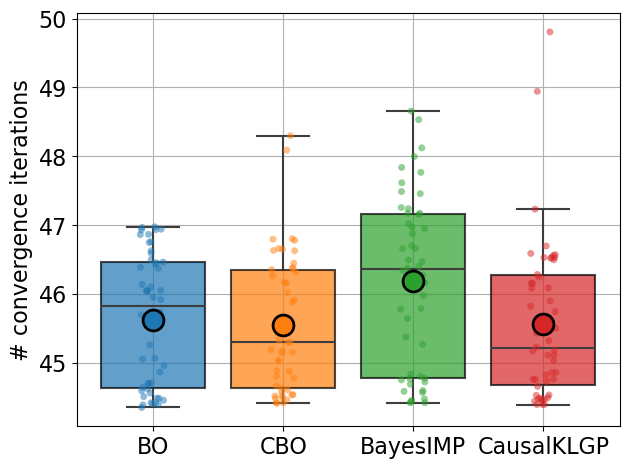

In [25]:
# Convert the tensor to a numpy array and then to a long format for seaborn
data_array = data_tensor.numpy()
data_long = np.vstack([np.column_stack((np.repeat(names[i], N), data_array[:, i])) for i in range(M)])

# Convert the numpy array to appropriate data types for seaborn
models = data_long[:, 0]
estimation_results = data_long[:, 1].astype(float)

# Set up the matplotlib figure
#plt.figure(figsize=(6, 5))

# Use the first four default matplotlib colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:M]

# Overlay a stripplot to show individual data points
sns.stripplot(x=models, y=estimation_results, hue=models, palette=colors, size=5, color='black', alpha=0.5, jitter=True, dodge=False, legend=False)

# Create a box plot with enhanced aesthetics
sns.boxplot(x=models, y=estimation_results, hue=models, palette=colors, linewidth=1.5, fliersize=0, dodge=False, legend=False)

# Add a gradient background
for i in range(M):
    plt.gca().patches[i].set_facecolor(colors[i])
    plt.gca().patches[i].set_edgecolor('black')
    plt.gca().patches[i].set_alpha(0.7)

# Add a title and labels with some styling
plt.ylabel('# convergence iterations', fontsize=16)
# Change grid lines to solid
plt.grid()

# Calculate and label the mean instead of the median
means = [np.mean(estimation_results[models == names[i]]) for i in range(M)]
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color=colors[i], markersize=15, markeredgewidth=2, markeredgecolor='black', zorder = 100)


# Customizing the ticks and spines for a cleaner look
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


# Show the plot
plt.tight_layout()
plt.savefig("CBO_box_plot", bbox_inches = "tight")